# PCA as a Preprocessing Step: Introduction to Pipelines

In this lecture, we will explore **Principal Component Analysis (PCA)** as a tool for dimensionality reduction and understand that machine learning workflows often require pipelines composed of multiple steps — including preprocessing techniques like PCA.

By the end of the lecture, you should be able to:

- Understand why dimensionality reduction techniques such as PCA are useful in applied machine learning.
- Recognize how PCA fits into a real-world modeling pipeline as a preprocessing step.
- Implement and evaluate a complete pipeline combining **PCA** and **Penalized regression**.

## 1. Refreshing Principal Component Analysis 

**PCA works by finding directions (called components) in the data that maximize variance**.

Let us now review what these components represent in practice. To do this, we will create some synthetic data where the features are intentionally correlated.

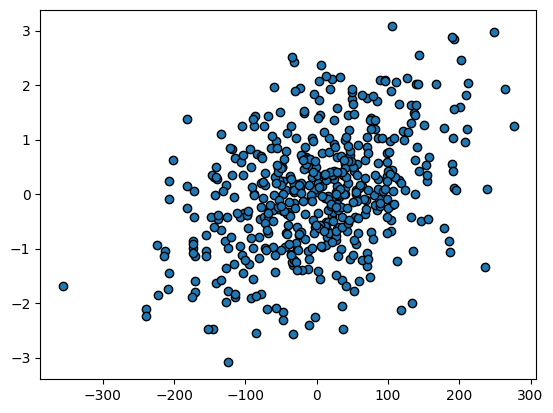

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_low_rank_matrix

rng = np.random.RandomState(1234)
x_1 = rng.randn((500))
x_2 = 0.4*x_1 + rng.randn((500))

X_synthetic = np.column_stack((x_1*100, x_2))

fig, ax = plt.subplots()
ax.scatter(X_synthetic[:,0], X_synthetic[:,1], zorder=0, edgecolors="k", )

Let us apply PCA and visualize its first principal component. We will use the implementation provided by `scikit-learn`.

Text(0, 0, '')

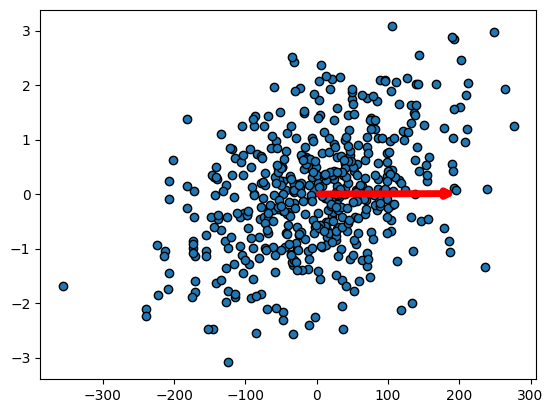

In [2]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_synthetic)

fig, ax = plt.subplots()
ax.scatter(X_synthetic[:,0], X_synthetic[:,1], zorder=0, edgecolors="k", )
ax.annotate("", xytext=(0, 0), xy=(pca.components_[0][0]*200, pca.components_[0][1]*2),
            arrowprops=dict(arrowstyle="->", linewidth=5, color="red"))

Hmm, interesting... As you can see, the first principal component is dominated by the feature with the largest units.

This happens because the **covariance matrix** — which PCA is based on — is heavily influenced by the scale of the variables. Features with larger numerical ranges contribute more to the overall variance, and therefore tend to dominate the principal components.

In [3]:
np.cov(X_synthetic.T)

array([[9.22537856e+03, 4.12185766e+01],
       [4.12185766e+01, 1.15704301e+00]])

Let us now see what happens when we standardize the data. For this, we will use `StandardScaler` from `scikit-learn`.

Text(0, 0, '')

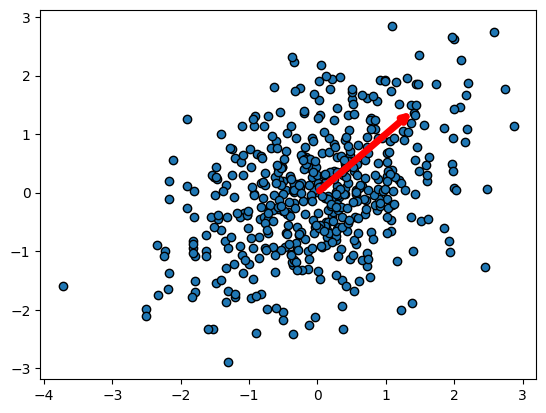

In [4]:
from sklearn.preprocessing import StandardScaler

pca = PCA()
X_synthetic_ss = StandardScaler().fit_transform(X_synthetic)
pca.fit(X_synthetic_ss)

fig, ax = plt.subplots()
ax.scatter(X_synthetic_ss[:,0], X_synthetic_ss[:,1], zorder=0, edgecolors="k", )
ax.annotate("", xytext=(0, 0), xy=(pca.components_[0][0]*2, pca.components_[0][1]*2),
            arrowprops=dict(arrowstyle="->", linewidth=5, color="red"))

Now, the covariance matrix is no longer dominated by any particular feature, so all features—at least in principle—contribute equally to the principal components.

In [5]:
np.cov(X_synthetic_ss.T)

array([[1.00200401, 0.39975656],
       [0.39975656, 1.00200401]])

As you can see, the extra diagonal term corresponds to the correlation between the two original features. This happens because standardizing your features and then applying PCA is equivalent to finding the directions that maximize the correlation matrix.

<div class="alert alert-info"> 

It is common practice to perform some form of normalization before applying PCA. This is especially important when your features have different scales, since PCA is **sensitive** to the relative magnitude of each feature.

</div>

<div class="alert alert-info"> 

📢❗🚨 𝐈𝐌𝐏𝐎𝐑𝐓𝐀𝐍𝐓 📢❗🚨

You should always center your data before applying PCA. Fortunately, if you are using `PCA` from `scikit-learn`, centering is performed automatically.

</div>

So, in a nutshell:

- **Without normalization** → PCA is based on the **covariance matrix** → Features with larger scales tend to dominate.
- **With normalization** (e.g., standardization) → PCA is effectively based on the **correlation matrix** → All features contribute more equally, based on their relationships.

As you can see, it is natural, common, and sometimes even necessary to **chain multiple steps** in a machine learning workflow. Please hold on to that idea—we will come back to it shortly.

## 2. PCA as a Tool to Inspect the Structure of the Data

You have probably seen **Principal Component Analysis (PCA)** used as a dimensionality reduction technique to inspect the structure of the data through visualization.

Let us explore this using the **FashionMNIST** dataset — a collection of Zalando's article images consisting of 60,000 training examples and 10,000 test examples.  (See more at: https://en.wikipedia.org/wiki/Fashion_MNIST)

For this part of the lesson, we will focus only on the training set.

You can find this dataset as part of [torchvision](https://docs.pytorch.org/vision/stable/index.html).

In [6]:
import torchvision
data = torchvision.datasets.FashionMNIST(root=".", download=True)

data_minst, labels = data.data.numpy(), data.targets.numpy()
data_minst_flatten = np.row_stack([dat.flatten() for dat in data_minst])
(n_samples, n_features), n_labels = data_minst_flatten.shape, np.unique(labels).size

print(f"This dataset have # classes: {n_labels}; # samples: {n_samples}; # features {n_features}")

This dataset have # classes: 10; # samples: 60000; # features 784


Each observation corresponds to fashion products one image (28 x 28) from 10 categories. The different categories are:

In [7]:
data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

We can further inspect the different classes by plotting one representative image from each category:

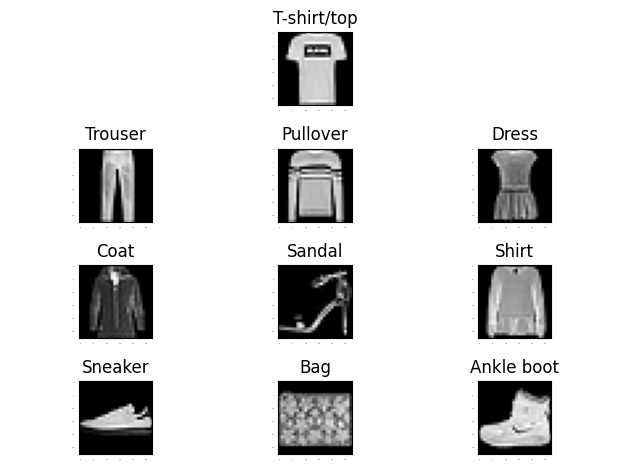

In [8]:
fig, axs = plt.subplots(nrows=4, ncols=3)
axs = axs.flatten()
axs[0].set_axis_off()
axs[1].imshow(data_minst[labels==0][0,:,:], cmap=plt.cm.binary_r)
axs[1].set_title(data.classes[0])
axs[2].set_axis_off()
for ii, ax in zip(range(1, 11), axs[3:]):
    ax.imshow(data_minst[labels==ii][0,:,:], cmap=plt.cm.binary_r)
    ax.set_title(data.classes[ii])
for ax in axs:
    ax.tick_params(size=0, labelsize=0)

fig.tight_layout()

Let's normalize the features in our dataset to a range between 0 and 1. To do that, we just need to divide by 255.

In [9]:
data_minst_flatten_norm = data_minst_flatten/255

And now, let’s apply PCA without specifying the number of components.

**Question**: Read the documentation for the PCA class. What will the number of principal components be if we don’t set this hyperparameter explicitly? And why?

In [10]:
pca = PCA()
reduced_data = pca.fit_transform(data_minst_flatten_norm)

Now, let's plot only the first two principal components.

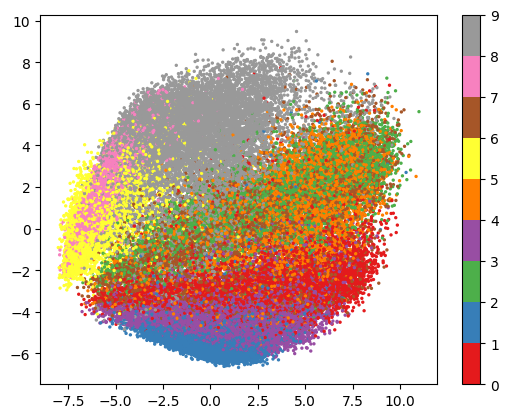

In [11]:
fig = plt.figure()
ax = fig.subplots()
im = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, s=2, cmap=plt.cm.Set1)
plt.colorbar(im)

As you can see, this visualization helps us better understand how separable the classes are. Most classes appear to be well separated, with the exception of coats, pullovers, and shirts, which show noticeable overlap.

But how much variance do these two components actually explain? Let us calculate it. With the implementation from `scikit-learn`, this is straightforward by inspecting the `.explained_variance_ratio_` attribute.

In [12]:
# Cumulative explained variance
cum_exp_variance = np.cumsum(pca.explained_variance_)

# Return the pca object for further use
print(f"The first 2 PCs explain in total {cum_exp_variance[1]:.3f} of variance. "
      f"Specifically, the first one taking {pca.explained_variance_[0]:.3f} and the second {pca.explained_variance_[1]:.2f}")

The first 2 PCs explain in total 31.922 of variance. Specifically, the first one taking 19.810 and the second 12.11


So, how about we decide to reconstruct our data using only the first two principal components?

We can do this by first projecting the data onto the first two PCs, and then mapping it back to the original feature space. 

In `sklearn`, this can be done easily using the `transform` and `inverse_transform` methods.

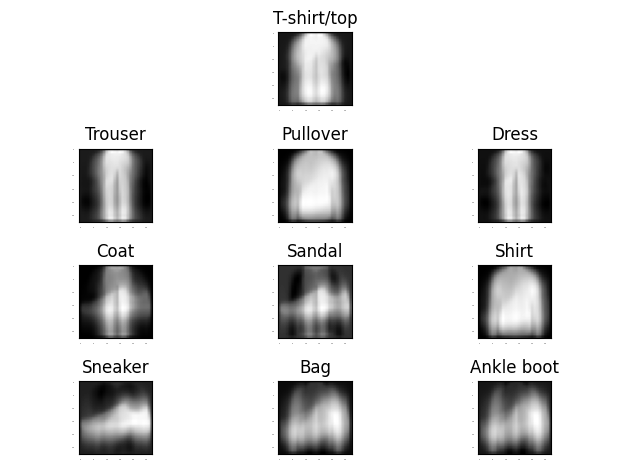

In [13]:
pca_only_2 = PCA(n_components=2)
data_minst_reconstruct2 = pca_only_2.inverse_transform(pca_only_2.fit_transform(data_minst_flatten_norm))

fig, axs = plt.subplots(nrows=4, ncols=3)
axs = axs.flatten()
axs[0].set_axis_off()
axs[1].imshow(data_minst_reconstruct2[labels==0][0,:].reshape(28,28), cmap=plt.cm.binary_r)
axs[1].set_title(data.classes[0])
axs[2].set_axis_off()
for ii, ax in zip(range(1, 11), axs[3:]):
    ax.imshow(data_minst_reconstruct2[labels==ii][0,:].reshape(28,28), cmap=plt.cm.binary_r)
    ax.set_title(data.classes[ii])
for ax in axs:
    ax.tick_params(size=0, labelsize=0)

fig.tight_layout()

As we can see, this dimensionality reduction results in a noticeable loss of quality — in other words, a loss of signal.

But that makes sense: after all, the two components we used account for only **31.92%** of the total variance in the data.

So, do we need more components? And if so, how many?

To answer that, let us create a **scree plot**, which shows the cumulative explained variance as we include more and more principal components.

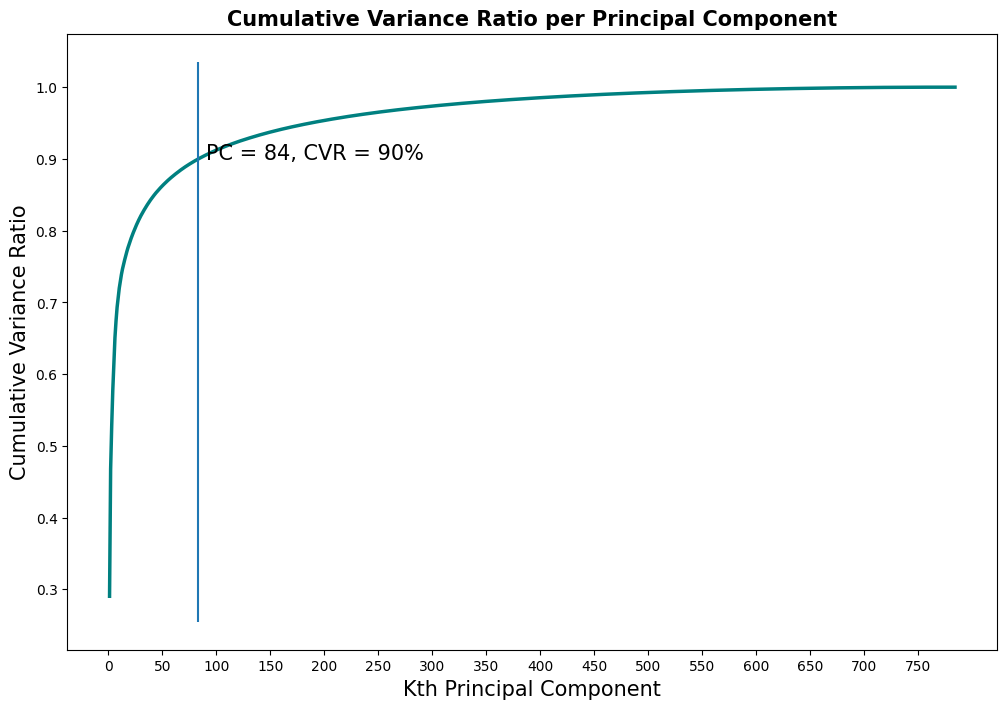

In [14]:
# Set plot specifications

fig = plt.figure(figsize=(12,8))
lw = 2.5

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
first_evec_90 = np.where(cumulative_variance_ratio >= 0.9)[0][0]

# Plot cumulative explained variance ratio
list_pcs = list(range(1, len(explained_variance_ratio)+1))
plt.plot(list_pcs, np.cumsum(explained_variance_ratio), color= 'teal', linewidth = lw)
ymin, ymax = plt.gca().get_ylim()
plt.vlines(first_evec_90, ymin=ymin, ymax=ymax)
plt.annotate("PC = "+str(first_evec_90+1)+", CVR = 90%", (90, 0.9)).set_fontsize(15)
plt.title('Cumulative Variance Ratio per Principal Component',fontsize=15, fontweight="bold")
plt.xticks(np.arange(0,len(list_pcs), 50))
plt.xlabel('Kth Principal Component', fontsize = 15)
plt.ylabel('Cumulative Variance Ratio', fontsize = 15)
plt.show()

As you can see, the cumulative explained variance begins to plateau at around 84 components, which together account for approximately 90% of the total variance. This suggests that adding more components beyond this point may not provide substantial additional information.

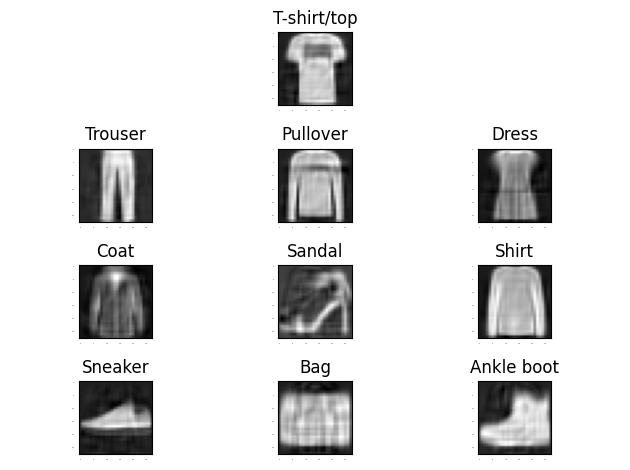

In [15]:
pca_only_84 = PCA(n_components=84)
data_minst_reconstruct84 = pca_only_84.inverse_transform(pca_only_84.fit_transform(data_minst_flatten_norm))

fig, axs = plt.subplots(nrows=4, ncols=3)
axs = axs.flatten()
axs[0].set_axis_off()
axs[1].imshow(data_minst_reconstruct84[labels==0][0,:].reshape(28,28), cmap=plt.cm.binary_r)
axs[1].set_title(data.classes[0])
axs[2].set_axis_off()
for ii, ax in zip(range(1, 11), axs[3:]):
    ax.imshow(data_minst_reconstruct84[labels==ii][0,:].reshape(28,28), cmap=plt.cm.binary_r)
    ax.set_title(data.classes[ii])
for ax in axs:
    ax.tick_params(size=0, labelsize=0)

fig.tight_layout()

Nice!

As we can see, we have successfully reduced the data from 784 to 84 dimensions while retaining a substantial amount of the original information — enough to still distinguish between classes. This suggests that we can reduce the dimensionality with likely minimal impact on performance.

But if reducing the data means losing information, why do it at all?

In real-world scenarios, datasets often have:

- A large number of features (sometimes hundreds or thousands)
- High collinearity between variables
- Redundant or noisy information

These issues can make models — particularly linear ones — unstable and prone to overfitting.

**PCA helps address these challenges and serves as an effective preprocessing tool.**

**This means it can be integrated directly into the predictive modeling pipeline — just like scaling, feature selection, or the machine learning algorithm itself.**

##  3- Applied Modelling Pipelines: PCA + (penalized) regression 

In typical machine learning applications, models are rarely used in isolation. Instead, we build pipelines that include preprocessing steps to support both **performance** and **interpretability**. An example of this—which we’ll now focus on—is:

Data →
Standardization →
PCA →
Regularized Regression →
Prediction

This pipeline has been applied in real-life research, such as in the following paper: https://doi.org/10.1161/JAHA.117.006053. The study aimed to determine whether multivariate patterns of stressor-evoked brain activity could account for individual differences in blood pressure reactivity—a stress-related cardiovascular risk factor.

Let's first load the dataset, which, given its size, is stored in google drive -- we will use `gdown` to download it:

In [16]:
!pip install -q gdown
!gdown 1ZEbBVrv3VuY_0OAiEdAuhKUlhDGReiWz --output data_neuro_ds4021.npz

Downloading...
From (original): https://drive.google.com/uc?id=1ZEbBVrv3VuY_0OAiEdAuhKUlhDGReiWz
From (redirected): https://drive.google.com/uc?id=1ZEbBVrv3VuY_0OAiEdAuhKUlhDGReiWz&confirm=t&uuid=a02921d6-5e7e-4d9a-9879-70d229b3fc19
To: /home/javi/Documentos/docencia/DS-4021/module-2/data_neuro_ds4021.npz
100%|████████████████████████████████████████| 156M/156M [00:13<00:00, 11.3MB/s]


In [17]:
X = np.load("data_neuro_ds4021.npz", allow_pickle=True)["X"]
y = np.load("data_neuro_ds4021.npz", allow_pickle=True)["y"]

print(f"The number of observations is: {X.shape[0]}, while the number of features is {X.shape[1]}") 

The number of observations is: 200, while the number of features is 207584


As you can see, **the number of features far exceeds the number of observations**. As a result, applying dimensionality reduction here might be a good idea!

On top of that, the input data here consists of brain activation maps, which quantify how strongly each location in the brain is activated relative to a baseline during task performance. Let’s have a look at a group-averaged map to give you a better sense of what this looks like:

Downloading...
From: https://drive.google.com/uc?id=1-GHjGK5xFZxWl42yE0GLF8HekN-ToGFQ
To: /home/javi/Documentos/docencia/DS-4021/module-2/activation_class04.png
100%|███████████████████████████████████████| 48.4k/48.4k [00:00<00:00, 174MB/s]


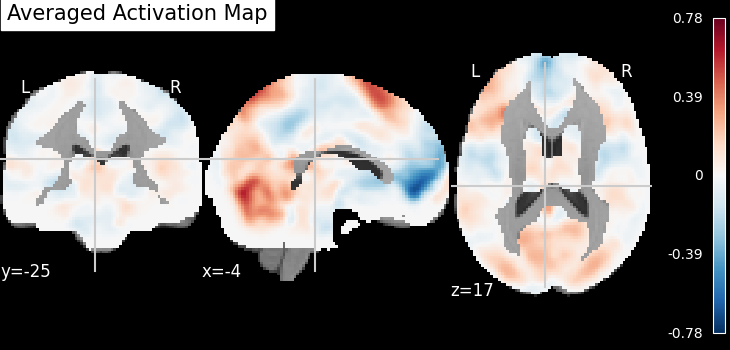

In [18]:
from IPython import display
!gdown 1-GHjGK5xFZxWl42yE0GLF8HekN-ToGFQ --output activation_class04.png
display.Image("activation_class04.png")

Here, brighter colors indicate stronger activations or deactivations. As you can see, regions surrounding strongly activated brain areas also tend to show increased activation. This is due to the spatial correlation inherent in brain data. Since we are using brain activation values as features, this leads to **multicollinearity**. As a result, using a method that can handle multicollinearity may be beneficial—and that is exactly what PCA is designed to do.

That’s why, in this paper, the authors chose to embed PCA before the regression model. The goal was to reduce the dimensionality of the data while generating new uncorrelated features, thereby avoiding multicollinearity issues. Additionally, to obtain a more parsimonious model, they applied constrained regression using a Lasso penalty.

So we have the following pipeline:

Data →
Standardization →
PCA →
Regularized Regression →
Prediction

This is a machine learning application, so any prediction we make should be tested on a held-out or independent dataset:

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

<div class="alert alert-info"> 

📢❗🚨 𝐈𝐌𝐏𝐎𝐑𝐓𝐀𝐍𝐓 📢❗🚨

**The entire pipeline should be considered the predictive model. This means that every step— including preprocessing—must be applied within the train/test split framework. Otherwise, you risk introducing data leakage, which can lead to overly optimistic performance estimates and poor generalization.**

</div>

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

# We first need to standardize the data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

# And this is followed by PCA
pca = PCA()
X_train_ss_pca = pca.fit_transform(X_train_ss)
X_test_ss_pca = pca.transform(X_test_ss)

lasso = Lasso()
lasso.fit(X_train_ss_pca, y_train)
print(f"R2 is equal to ", r2_score(y_test, lasso.predict(X_test_ss_pca)))

R2 is equal to  0.14062695100772016


This works, but as you can see, the amount of code required might be high—especially as the pipeline becomes more complex. Moreover, we have to keep reusing and carrying forward previous definitions, which can make the entire process more error-prone and harder to manage.

### Pipelines in `scikit-learn`

Fortunately, scikit-learn offers one of the most powerful features available in any ML library: the `pipeline` module. This tool allows you to chain multiple preprocessing and modeling steps into a single object. It provides several important advantages:

- It improves both convenience and encapsulation, since you only need to call `.fit()` and `.predict()` once to apply the entire sequence of steps.

- You can perform grid search over the parameters of all components in the pipeline at once.

- Pipelines help prevent data leakage during cross-validation by ensuring that all transformations are learned only on the training folds, and then applied to the corresponding test folds.

In short, pipelines make your code cleaner, safer, and easier to maintain.

To build a pipeline, we just just use the `Pipeline` class and pass a list of (key, value) pairs, where the key is a string containing the name you want to give this step and value is an estimator object.

In [21]:
from sklearn.pipeline import Pipeline

pip = Pipeline([("scaler", ss), ("pca", pca), ("lasso", lasso)])

The pipeline behaves like a single estimator, meaning you can call fit and predict on it just as you would with any model. Each step is executed in sequence, with the output of one step passed as input to the next.

In [22]:
# Fit on the training
pip.fit(X_train, y_train)

# And then predict 
y_pred = pip.predict(X_test)

print(f"R2 is equal to ", r2_score(y_test, y_pred))

R2 is equal to  0.14062695100772016


### Optimizing Your Pipeline

As we mentioned earlier, the entire pipeline should be considered the predictive model. This means that we may need to optimize its various hyperparameters — not just those of the final estimator.

In this example, we focus on tuning **$\lambda$**, the coefficient that multiplies the regularization term in **Lasso regression**.

Since the pipeline object behaves like a single estimator, we can easily pass it to `GridSearchCV` and use cross-validation (on the **training set!**) to tune hyperparameters across the entire pipeline — while avoiding any risk of data leakage.

For example, suppose we want to select the best value for $\lambda$ from a set of 5 candidate values.

In [23]:
from sklearn.model_selection import GridSearchCV, KFold
cv_inner = KFold(n_splits=3, random_state=123, shuffle=True)

param_grid = {"lasso__alpha": [0.01, 0.1, 0.5, 1, 10]}

pip = Pipeline([("scaler", ss), ("pca", pca), ("lasso", lasso)])
grid = GridSearchCV(pip, 
                    param_grid=param_grid, 
                    cv=cv_inner, n_jobs=10, verbose=1, scoring="neg_mean_squared_error")

grid.fit(X_train, y_train)

# And then predict 
y_pred = grid.predict(X_test)

print(f"R2 is equal to ", r2_score(y_test, y_pred))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
R2 is equal to  0.10937297797666268


For more info about the module `pipeline` https://scikit-learn.org/stable/modules/compose.html

## 5. Summary:

- PCA can be a powerful preprocessing step when working with high-dimensional data, especially when features are highly correlated or redundant.

- PCA is just one of many possible preprocessing steps you might include in a machine learning workflow.

- Preprocessing steps that involve estimating parameters from the data (such as scaling, PCA, or feature selection) should be fit only on the training set, not the full dataset. As a result, these steps are part of the overall modeling pipeline and must follow standard machine learning practices to avoid data leakage.

## 📝 5 - Exercise -- Comparing LDA with PCA + Lasso Logistic Regression

In this exercise, you will compare two approaches for classification:

- A pipeline that applies **Linear Discriminant Analysis (LDA)**.
- A pipeline that applies **Principal Component Analysis (PCA)** followed by **Logistic Regression with L1 penalty** (Lasso).

In order to do this, you will be working with the DARWIN dataset, which was created to help prediction of Alzheimer's disease via handwriting analysis. (Source: https://archive.ics.uci.edu/dataset/732/darwin)

Here below is the data, which has been previously curated for this exercise and can be conveniently loaded by executing the following code:

In [24]:
X = np.loadtxt("https://raw.githubusercontent.com/UVADS/DS-4021/refs/heads/main/datasets/darwin_features.txt")
y = np.loadtxt("https://raw.githubusercontent.com/UVADS/DS-4021/refs/heads/main/datasets/darwin_labels.txt")

print(f"Input data has {X.shape[0]} observations, and {X.shape[1]} features")

Input data has 174 observations, and 300 features


You should do the following:

---

1. **Reflection**: Before running any code, take a few minutes to answer the following questions:
    - What is the difference between **Linear Discriminant Analysis (LDA)** and **Principal Component Analysis (PCA) combined with regression**?
    - Why do you believe these two methods are appropriate for this dataset?

---

2. **Train-test split**. Split the data into training and test sets. Use 80% of the data for training. Make sure the split preserves the distribution of classes.
---

3. **Explore feature correlations**:
    - Plot a heatmap showing the correlation between float features in the training set. 
    - Do you see potential collinearity issues among features?

---

4. **LDA pipeline**: create a pipeline that first scales the features and then applies LDA. Train it on the training set and evaluate its performance on the test set.

---

5. **PCA + Lasso pipeline**:

   - Create a pipeline that first scales the features, then applies PCA (retaining 95% of the variance), and finally applies logistic regression with an L1 penalty. Use cross-validation to choose the best value of the penalty parameter.
   - Train this pipeline on the training set and evaluate it on the test set.
---
6. **Compare performance**. Which of both pipeline performs better? Why do you think this is the case?
---
7. **(BONUS) Compare the projected data from PCA and LDA**:

   - Project the training data using both PCA and LDA.
   - Then, for each of the top principal components, compute the correlation between the LDA projections and PCA projections.
   - Do any of the principal components strongly correlate with the LDA projection? If not, what does this suggest about the relationship between the directions that capture variance (PCA) and those that separate classes (LDA)?
---

Feel free to use as many cells as need for all this.

In [25]:
# YOUR CODE FROM HERE